# Загрузка данных

In [2]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

import lightgbm as lgb

import pickle

In [3]:
# Загрузка данных без дополнительных признаков и их соединение
train = pd.read_excel("data/train.xlsx")
test = pd.read_excel("data/test.xlsx")
df = pd.concat([train, test]).sort_values("dt").reset_index(drop=True)

In [4]:
# преобразование даты и добавление новых колонок на основе даты
df["dt"] = pd.to_datetime(df["dt"])
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month
df["day"] = df["dt"].dt.day
df["week"] = df["dt"].dt.isocalendar().week

In [5]:
# создание лагов и удаление пропущенных значений, которые создаются вместе в них (количество лагов беру из анализа)
for lag in [1, 2]: 
    df[f"lag_{lag}"] = df["Цена на арматуру"].shift(lag)

df

,dt,Цена на арматуру,year,month,day,week,lag_1,lag_2
0,2015-01-05,32900,2015,1,5,2,NaN,NaN
1,2015-01-12,32500,2015,1,12,3,32900.0,NaN
2,2015-01-19,32000,2015,1,19,4,32500.0,32900.0
3,2015-01-26,30700,2015,1,26,5,32000.0,32500.0
4,2015-02-02,30300,2015,2,2,6,30700.0,32000.0
...,...,...,...,...,...,...,...,...
423,2023-02-13,44500,2023,2,13,7,44500.0,42800.0
424,2023-02-20,46000,2023,2,20,8,44500.0,44500.0
425,2023-02-27,49200,2023,2,27,9,46000.0,44500.0
426,2023-03-06,53700,2023,3,6,10,49200.0,46000.0


In [6]:
# удаление пропусков
df = df.dropna()

In [7]:
df.to_csv("historical_data.csv", index=True)

In [8]:
# разделение на обучающую и тестовую выборки в процентном соотношении 80 к 20
train_size = int(len(df) * 0.85)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train = train.drop(["dt", "Цена на арматуру"], axis=1)
y_train = train["Цена на арматуру"]
X_test = test.drop(["dt", "Цена на арматуру"], axis=1)
y_test = test["Цена на арматуру"]

In [9]:
# cоздание и обучение модели
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 362, number of used features: 6
[LightGBM] [Info] Start training from score 37464.889503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=500,
              random_state=42)

In [10]:
# прогнозирование
predictions = model.predict(X_test)

# оценка модели с помощью метрик
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.9106
MAPE: 0.05
MAE: 2374.04


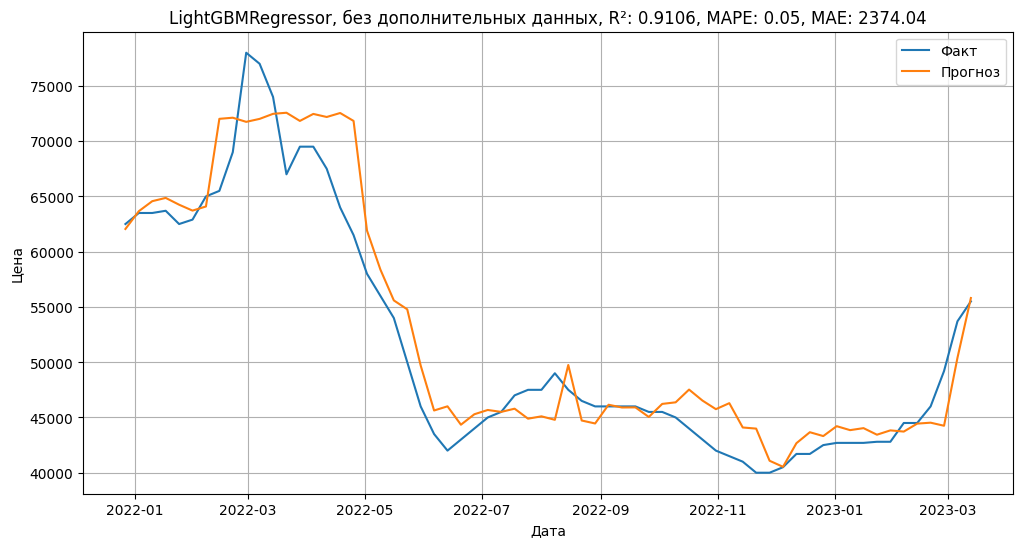

In [13]:
# визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test["dt"], y_test, label="Факт")
plt.plot(test["dt"], predictions, label="Прогноз")
plt.title(f"LightGBMRegressor, без дополнительных данных, R²: {r2:.4f}, MAPE: {mape:.2f}, MAE: {mae:.2f}")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.grid()
plt.show()

In [12]:
with open('lgbm_model.pkl', 'wb') as f: pickle.dump(model, f)